In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator

In [18]:
plt.rcParams['font.size'] = 15
plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams['xtick.major.pad']=30
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Times New Roman'
matplotlib.rcParams['mathtext.it'] = 'Times New Roman:italic'
matplotlib.rcParams['mathtext.bf'] = 'Times New Roman:bold'
matplotlib.rcParams['font.size'] = 14

In [19]:
class LinearNDInterpolatorExt(object):
    def __init__(self, points,values):
        self.funcinterp = LinearNDInterpolator(points,values)
        self.funcnearest = NearestNDInterpolator(points,values)
    def __call__(self,*args):
        t = self.funcinterp(*args)
        if not np.isnan(t):
            return t.item(0)
        else:
            return self.funcnearest(*args)

In [20]:
def angle_loss(output, target):
    # output_angle = output * torch.pi / 180
    # target_angle = target * torch.pi / 180
    # loss = torch.mean((torch.cos(output_angle) - torch.cos(target_angle))**2 + \
    #                   (torch.sin(output_angle) - torch.sin(target_angle))**2)
    loss = torch.mean(torch.min(torch.abs(output - target), torch.abs(360 + output - target)))
    return loss

In [21]:

# nside = 16
# npix = hp.nside2npix(nside)
# thetas = np.radians(real_inc + 90)
# thetas[thetas > np.pi] = np.pi
# phis = np.radians(real_PA)
# fs = error
# the_phi = np.c_[thetas, phis]
# lut2 = LinearNDInterpolatorExt(the_phi, fs)
# N = int(10e5)
# Theta = np.random.uniform(0, np.pi, N)
# Phi = np.random.uniform(0, 2*np.pi, N)
# interpolate_points = np.zeros(N, dtype=np.float16)
# for ii in range(N):
#     interpolate_points[ii] = lut2(Theta[ii], Phi[ii])
# Fs = interpolate_points

# indices = hp.ang2pix(nside, Theta, Phi)
# hpxmap = np.zeros(npix, dtype=np.float32)
# for i in range(N):
#     hpxmap[indices[i]] = Fs[i]
# # hp.mollview(hpxmap, title='Loss for inclination and PA')
# # plt.savefig('images/skymap.png', dpi=600)
# # plt.savefig('images/skymap.pdf')

# # classic healpy mollweide projections plot with graticule
# projview(
#     hpxmap, coord=["G"], graticule=True, graticule_labels=True, projection_type="mollweide"
# )
# plt.show()




# plt.savefig('images/skymap_grid.png', dpi=600)
# plt.savefig('images/skymap_grid.pdf')

# # polar view
# projview(
#     hpxmap,
#     coord=["G"],
#     hold=False,
#     graticule=True,
#     graticule_labels=True,
#     flip="astro",
#     projection_type="polar",
#     unit="cbar label",
#     cb_orientation="horizontal",
#     override_plot_properties={
#         "cbar_shrink": 0.5,
#         "cbar_pad": 0.02,
#         "cbar_label_pad": -35,
#         "figure_width": 16,
#         "figure_size_ratio": 0.63,
#     },
# );
# plt.savefig('images/skymap_polar.png', dpi=600)
# plt.savefig('images/skymap_polar.pdf')


In [22]:
# error.shape

C:\Users\FYQ\AppData\Local\Temp\ipykernel_23428\1670508274.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.19, 1, 1])


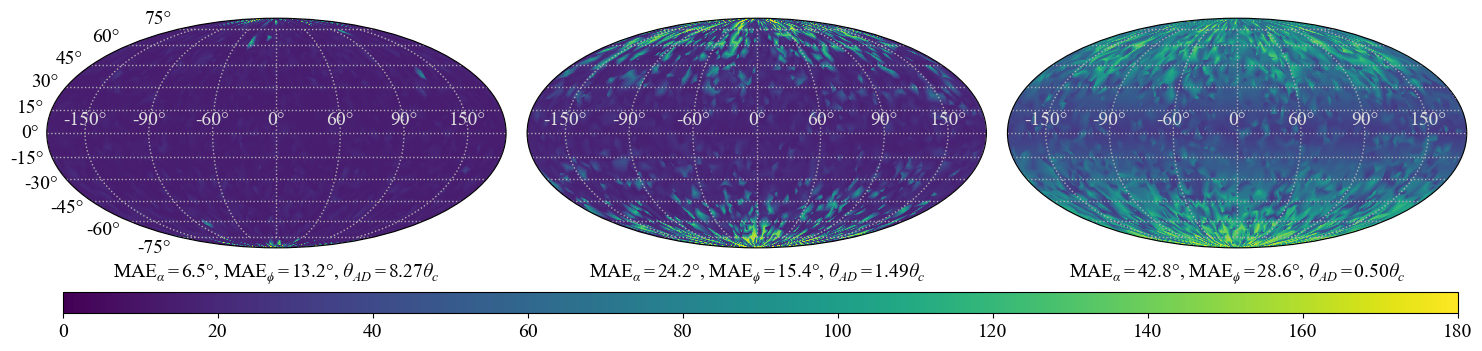

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5), subplot_kw={'projection' :'mollweide'})
cbar_ax = fig.add_axes([.05, .08, .93, .06])
csv_paths = ['acc-6.475', 'acc-24.166', 'acc-42.799']
mae_pa = [13.162182966868, 15.4489304754469, 28.578175968594]
angular_sizes = [5e-4, 9e-5, 3e-5]
b = re.compile(r'(\d+\.\d+)')
for index, csv_path in enumerate(csv_paths):
    ax = axes[index]
    # ax.set_pro
    mae = b.search(csv_path).group(1)
    mae = float(mae)
    df = pd.read_csv(f'csv/{csv_path}.csv')
    pred_inc = df.Pred_inc.to_numpy()
    pred_PA = df.Pred_PA.to_numpy()
    real_inc = df.Real_inc.to_numpy()
    real_PA = df.Real_PA.to_numpy()
    err_inc = np.radians(np.abs(pred_inc - real_inc))
    err_PA = np.radians(angle_loss(torch.tensor(pred_PA), torch.tensor(real_PA)).numpy())
    error = err_inc + err_PA
    error = np.degrees(error)
    real_PA = np.radians(real_PA) - np.pi
    real_inc = np.radians(real_inc)
    interp = LinearNDInterpolator(list(zip(real_PA, real_inc)), error)
    lon = np.linspace(-np.pi, np.pi, 900)
    lat = np.linspace(-np.pi/2., np.pi/2., 450)
    Lon,Lat = np.meshgrid(lon,lat)
    Error = interp(Lon, Lat)
    # Error = np.random.uniform(0, 1, (45, 90))
    # ax = fig.add_subplot(111, )
    im = ax.pcolormesh(Lon, Lat, Error, cmap='viridis', vmin=0, vmax=180, rasterized=True)
    ax.grid('on', linestyle=':', linewidth=1)
    if index != 0:
        ax.set_yticklabels([])
    ax.set_xticks(np.radians(np.arange(-150, 151, 50)), )
    ax.tick_params(axis='x', colors='#dddddd')
    ax.set_xlabel(rf'MAE$_{{\alpha}}={mae:.1f}\degree$, MAE$_{{\phi}}={mae_pa[index]:.1f}\degree$, '
                  rf'$\theta_{{AD}}={angular_sizes[index]*64/3.87e-3:.2f}\theta_c$', labelpad=10)
    # ax.tick_params(axis='x', which='major', pad=30)
    fig.colorbar(im, orientation='horizontal', cax=cbar_ax)
fig.tight_layout(rect=[0, 0.19, 1, 1])
# plt.savefig('images/skymap_grid3.png', dpi=600)
plt.savefig('images/skymap_grid3.pdf', dpi=300)
plt.show()

In [24]:
error.max()

182.60981501528644

In [25]:
interp(0.1, np.pi / 100)

array(52.13110105)